In [39]:
# Step 1
# import packages
import xlsxwriter
import re
import numpy as np
import pandas as pd

from pprint import pprint
from spacy.lang.en import English
from nltk.corpus import wordnet as wn

In [40]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
'exec(%matplotlib inline)'

'exec(%matplotlib inline)'

In [41]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# prepare stopwords
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# add customized stopwords here
# custome keywors for Simulink
# stop_words.extend(["'s","'m","..", "...", "n't", "simulink", "Simulink", "ca", "'ve", "model"])

# custome keywords for labVIEW
stop_words.extend(["\'m", "n\'t", "...", "\'s", "\'ve", "ca", 'labview','LabVIEW'])

parser = English()

In [42]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [43]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 1]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [get_lemma(token) for token in tokens]
    return tokens
#

In [44]:
#find the meanings of words, synonyms, antonyms
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# import data
text_data = []
text_forum = []

In [45]:
with open('1999-2019_Final_New.csv', encoding = "UTF-8") as f:
    for line in f:
        # if "//" not in line and "/" not in line and "\\" not in line and r'\'' not in line:
        text_forum.append(line)
        tokens = prepare_text_for_lda(line)
        text_data.append(tokens)

In [46]:
id2word = corpora.Dictionary(text_data)

#create corpus
texts = text_data

#term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [47]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Copyright (C) 2014 Radim Rehurek <radimrehurek@seznam.cz>
# Licensed under the GNU LGPL v2.1 - http://www.gnu.org/licenses/lgpl.html


r"""Python wrapper for `Latent Dirichlet Allocation (LDA) <https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation>`_
from `MALLET, the Java topic modelling toolkit <http://mallet.cs.umass.edu/>`_

This module allows both LDA model estimation from a training corpus and inference of topic distribution on new,
unseen documents, using an (optimized version of) collapsed gibbs sampling from MALLET.

Notes
-----
MALLET's LDA training requires :math:`O(corpus\_words)` of memory, keeping the entire corpus in RAM.
If you find yourself running out of memory, either decrease the `workers` constructor parameter,
or use :class:`gensim.models.ldamodel.LdaModel` or :class:`gensim.models.ldamulticore.LdaMulticore`
which needs only :math:`O(1)` memory.
The wrapped model can NOT be updated with new documents for online training -- use
:class:`~gensim.models.ldamodel.LdaModel` or :class:`~gensim.models.ldamulticore.LdaMulticore` for that.

Installation
------------
Use `official guide <http://mallet.cs.umass.edu/download.php>`_ or this one ::

    sudo apt-get install default-jdk
    sudo apt-get install ant
    git clone git@github.com:mimno/Mallet.git
    cd Mallet/
    ant

Examples
--------
.. sourcecode:: pycon

#    >>> from gensim.test.utils import common_corpus, common_dictionary
#    >>> from gensim.models.wrappers import LdaMallet
#    >>>
#    >>> path_to_mallet_binary = "/path/to/mallet/binary"
#    >>> model = LdaMallet(path_to_mallet_binary, corpus=common_corpus, num_topics=20, id2word=common_dictionary)
#    >>> vector = model[common_corpus[0]]  # LDA topics of a documents

"""


import logging
import os
import random
import warnings
import tempfile
import xml.etree.ElementTree as et
import zipfile
from itertools import chain

import numpy

from gensim import utils, matutils
from gensim.models import basemodel
from gensim.models.ldamodel import LdaModel
from gensim.utils import check_output, revdict

logger = logging.getLogger(__name__)


class LdaMallet(utils.SaveLoad, basemodel.BaseTopicModel):
    """Python wrapper for LDA using `MALLET <http://mallet.cs.umass.edu/>`_.

    Communication between MALLET and Python takes place by passing around data files on disk
    and calling Java with subprocess.call().

    Warnings
    --------
    This is **only** python wrapper for `MALLET LDA <http://mallet.cs.umass.edu/>`_,
    you need to install original implementation first and pass the path to binary to ``mallet_path``.

    """
    def __init__(self, mallet_path, corpus=None, num_topics=100, alpha=50, id2word=None, workers=4, prefix=None,
                 optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0):
        """

        Parameters
        ----------
        mallet_path : str
            Path to the mallet binary, e.g. `/home/username/mallet-2.0.7/bin/mallet`.
        corpus : iterable of iterable of (int, int), optional
            Collection of texts in BoW format.
        num_topics : int, optional
            Number of topics.
        alpha : int, optional
            Alpha parameter of LDA.
        id2word : :class:`~gensim.corpora.dictionary.Dictionary`, optional
            Mapping between tokens ids and words from corpus, if not specified - will be inferred from `corpus`.
        workers : int, optional
            Number of threads that will be used for training.
        prefix : str, optional
            Prefix for produced temporary files.
        optimize_interval : int, optional
            Optimize hyperparameters every `optimize_interval` iterations
            (sometimes leads to Java exception 0 to switch off hyperparameter optimization).
        iterations : int, optional
            Number of training iterations.
        topic_threshold : float, optional
            Threshold of the probability above which we consider a topic.
        random_seed: int, optional
            Random seed to ensure consistent results, if 0 - use system clock.

        """
        self.mallet_path = mallet_path
        self.id2word = id2word
        if self.id2word is None:
            logger.warning("no word id mapping provided; initializing from corpus, assuming identity")
            self.id2word = utils.dict_from_corpus(corpus)
            self.num_terms = len(self.id2word)
        else:
            self.num_terms = 0 if not self.id2word else 1 + max(self.id2word.keys())
        if self.num_terms == 0:
            raise ValueError("cannot compute LDA over an empty collection (no terms)")
        self.num_topics = num_topics
        self.topic_threshold = topic_threshold
        self.alpha = alpha
        if prefix is None:
            rand_prefix = hex(random.randint(0, 0xffffff))[2:] + '_'
            prefix = os.path.join(tempfile.gettempdir(), rand_prefix)
        self.prefix = prefix
        self.workers = workers
        self.optimize_interval = optimize_interval
        self.iterations = iterations
        self.random_seed = random_seed
        if corpus is not None:
            self.train(corpus)

    def finferencer(self):
        """Get path to inferencer.mallet file.

        Returns
        -------
        str
            Path to inferencer.mallet file.

        """
        return self.prefix + 'inferencer.mallet'

    def ftopickeys(self):
        """Get path to topic keys text file.

        Returns
        -------
        str
            Path to topic keys text file.

        """
        return self.prefix + 'topickeys.txt'

    def fstate(self):
        """Get path to temporary file.

        Returns
        -------
        str
            Path to file.

        """
        return self.prefix + 'state.mallet.gz'

    def fdoctopics(self):
        """Get path to document topic text file.

        Returns
        -------
        str
            Path to document topic text file.

        """
        return self.prefix + 'doctopics.txt'

    def fcorpustxt(self):
        """Get path to corpus text file.

        Returns
        -------
        str
            Path to corpus text file.

        """
        return self.prefix + 'corpus.txt'

    def fcorpusmallet(self):
        """Get path to corpus.mallet file.

        Returns
        -------
        str
            Path to corpus.mallet file.

        """
        return self.prefix + 'corpus.mallet'

    def fwordweights(self):
        """Get path to word weight file.

        Returns
        -------
        str
            Path to word weight file.

        """
        return self.prefix + 'wordweights.txt'

    def corpus2mallet(self, corpus, file_like):
        """Convert `corpus` to Mallet format and write it to `file_like` descriptor.

        Format ::

            document id[SPACE]label (not used)[SPACE]whitespace delimited utf8-encoded tokens[NEWLINE]

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        file_like : file-like object
            Opened file.

        """
        for docno, doc in enumerate(corpus):
            if self.id2word:
                tokens = chain.from_iterable([self.id2word[tokenid]] * int(cnt) for tokenid, cnt in doc)
            else:
                tokens = chain.from_iterable([str(tokenid)] * int(cnt) for tokenid, cnt in doc)
            file_like.write(utils.to_utf8("%s 0 %s\n" % (docno, ' '.join(tokens))))

    def convert_input(self, corpus, infer=False, serialize_corpus=True):
        """Convert corpus to Mallet format and save it to a temporary text file.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Collection of texts in BoW format.
        infer : bool, optional
            ...
        serialize_corpus : bool, optional
            ...

        """
        if serialize_corpus:
            logger.info("serializing temporary corpus to %s", self.fcorpustxt())
            with utils.open(self.fcorpustxt(), 'wb') as fout:
                self.corpus2mallet(corpus, fout)

        # convert the text file above into MALLET's internal format
        cmd = \
            self.mallet_path + \
            " import-file --preserve-case --keep-sequence " \
            "--remove-stopwords --token-regex \"\\S+\" --input %s --output %s"
        if infer:
            cmd += ' --use-pipe-from ' + self.fcorpusmallet()
            cmd = cmd % (self.fcorpustxt(), self.fcorpusmallet() + '.infer')
        else:
            cmd = cmd % (self.fcorpustxt(), self.fcorpusmallet())
        logger.info("converting temporary corpus to MALLET format with %s", cmd)
        check_output(args=cmd, shell=True)

    def train(self, corpus):
        """Train Mallet LDA.

        Parameters
        ----------
        corpus : iterable of iterable of (int, int)
            Corpus in BoW format

        """
        self.convert_input(corpus, infer=False)
        cmd = self.mallet_path + ' train-topics --input %s --num-topics %s  --alpha %s --optimize-interval %s '\
            '--num-threads %s --output-state %s --output-doc-topics %s --output-topic-keys %s '\
            '--num-iterations %s --inferencer-filename %s --doc-topics-threshold %s  --random-seed %s'

        cmd = cmd % (
            self.fcorpusmallet(), self.num_topics, self.alpha, self.optimize_interval,
            self.workers, self.fstate(), self.fdoctopics(), self.ftopickeys(), self.iterations,
            self.finferencer(), self.topic_threshold, str(self.random_seed)
        )
        # NOTE "--keep-sequence-bigrams" / "--use-ngrams true" poorer results + runs out of memory
        logger.info("training MALLET LDA with %s", cmd)
        check_output(args=cmd, shell=True)
        self.word_topics = self.load_word_topics()
        # NOTE - we are still keeping the wordtopics variable to not break backward compatibility.
        # word_topics has replaced wordtopics throughout the code;
        # wordtopics just stores the values of word_topics when train is called.
        self.wordtopics = self.word_topics

    def __getitem__(self, bow, iterations=100):
        """Get vector for document(s).

        Parameters
        ----------
        bow : {list of (int, int), iterable of list of (int, int)}
            Document (or corpus) in BoW format.
        iterations : int, optional
            Number of iterations that will be used for inferring.

        Returns
        -------
        list of (int, float)
            LDA vector for document as sequence of (topic_id, topic_probability) **OR**
        list of list of (int, float)
            LDA vectors for corpus in same format.

        """
        is_corpus, corpus = utils.is_corpus(bow)
        if not is_corpus:
            # query is a single document => make a corpus out of it
            bow = [bow]

        self.convert_input(bow, infer=True)
        cmd = \
            self.mallet_path + ' infer-topics --input %s --inferencer %s ' \
                               '--output-doc-topics %s --num-iterations %s --doc-topics-threshold %s --random-seed %s'
        cmd = cmd % (
            self.fcorpusmallet() + '.infer', self.finferencer(),
            self.fdoctopics() + '.infer', iterations, self.topic_threshold, str(self.random_seed)
        )
        logger.info("inferring topics with MALLET LDA '%s'", cmd)
        check_output(args=cmd, shell=True)
        result = list(self.read_doctopics(self.fdoctopics() + '.infer'))
        return result if is_corpus else result[0]

    def load_word_topics(self):
        """Load words X topics matrix from :meth:`gensim.models.wrappers.ldamallet.LdaMallet.fstate` file.

        Returns
        -------
        numpy.ndarray
            Matrix words X topics.

        """
        logger.info("loading assigned topics from %s", self.fstate())
        word_topics = numpy.zeros((self.num_topics, self.num_terms), dtype=numpy.float64)
        if hasattr(self.id2word, 'token2id'):
            word2id = self.id2word.token2id
        else:
            word2id = revdict(self.id2word)

        with utils.open(self.fstate(), 'rb') as fin:
            _ = next(fin)  # header
            self.alpha = numpy.fromiter(next(fin).split()[2:], dtype=float)
            assert len(self.alpha) == self.num_topics, "mismatch between MALLET vs. requested topics"
            _ = next(fin)  # noqa:F841 beta
            for lineno, line in enumerate(fin):
                line = utils.to_unicode(line)
                doc, source, pos, typeindex, token, topic = line.split(" ")
                if token not in word2id:
                    continue
                tokenid = word2id[token]
                word_topics[int(topic), tokenid] += 1.0
        return word_topics

    def load_document_topics(self):
        """Load document topics from :meth:`gensim.models.wrappers.ldamallet.LdaMallet.fdoctopics` file.
        Shortcut for :meth:`gensim.models.wrappers.ldamallet.LdaMallet.read_doctopics`.

        Returns
        -------
        iterator of list of (int, float)
            Sequence of LDA vectors for documents.

        """
        return self.read_doctopics(self.fdoctopics())

    def get_topics(self):
        """Get topics X words matrix.

        Returns
        -------
        numpy.ndarray
            Topics X words matrix, shape `num_topics` x `vocabulary_size`.

        """
        topics = self.word_topics
        return topics / topics.sum(axis=1)[:, None]

    def show_topics(self, num_topics=10, num_words=10, log=False, formatted=True):
        """Get the `num_words` most probable words for `num_topics` number of topics.

        Parameters
        ----------
        num_topics : int, optional
            Number of topics to return, set `-1` to get all topics.
        num_words : int, optional
            Number of words.
        log : bool, optional
            If True - write topic with logging too, used for debug proposes.
        formatted : bool, optional
            If `True` - return the topics as a list of strings, otherwise as lists of (weight, word) pairs.

        Returns
        -------
        list of str
            Topics as a list of strings (if formatted=True) **OR**
        list of (float, str)
            Topics as list of (weight, word) pairs (if formatted=False)

        """
        if num_topics < 0 or num_topics >= self.num_topics:
            num_topics = self.num_topics
            chosen_topics = range(num_topics)
        else:
            num_topics = min(num_topics, self.num_topics)
            # add a little random jitter, to randomize results around the same alpha
            sort_alpha = self.alpha + 0.0001 * numpy.random.rand(len(self.alpha))
            sorted_topics = list(matutils.argsort(sort_alpha))
            chosen_topics = sorted_topics[: num_topics // 2] + sorted_topics[-num_topics // 2:]
        shown = []
        for i in chosen_topics:
            if formatted:
                topic = self.print_topic(i, topn=num_words)
            else:
                topic = self.show_topic(i, topn=num_words)
            shown.append((i, topic))
            if log:
                logger.info("topic #%i (%.3f): %s", i, self.alpha[i], topic)
        return shown

    def show_topic(self, topicid, topn=10, num_words=None):
        """Get `num_words` most probable words for the given `topicid`.

        Parameters
        ----------
        topicid : int
            Id of topic.
        topn : int, optional
            Top number of topics that you'll receive.
        num_words : int, optional
            DEPRECATED PARAMETER, use `topn` instead.

        Returns
        -------
        list of (str, float)
            Sequence of probable words, as a list of `(word, word_probability)` for `topicid` topic.

        """
        if num_words is not None:  # deprecated num_words is used
            warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")
            topn = num_words

        if self.word_topics is None:
            logger.warning("Run train or load_word_topics before showing topics.")
        topic = self.word_topics[topicid]
        topic = topic / topic.sum()  # normalize to probability dist
        bestn = matutils.argsort(topic, topn, reverse=True)
        beststr = [(self.id2word[idx], topic[idx]) for idx in bestn]
        return beststr

    def get_version(self, direc_path):
        """"Get the version of Mallet.

        Parameters
        ----------
        direc_path : str
            Path to mallet archive.

        Returns
        -------
        str
            Version of mallet.

        """
        try:
            archive = zipfile.ZipFile(direc_path, 'r')
            if u'cc/mallet/regression/' not in archive.namelist():
                return '2.0.7'
            else:
                return '2.0.8RC3'
        except Exception:

            xml_path = direc_path.split("bin")[0]
            try:
                doc = et.parse(xml_path + "pom.xml").getroot()
                namespace = doc.tag[:doc.tag.index('}') + 1]
                return doc.find(namespace + 'version').text.split("-")[0]
            except Exception:
                return "Can't parse pom.xml version file"

    def read_doctopics(self, fname, eps=1e-6, renorm=True):
        """Get document topic vectors from MALLET's "doc-topics" format, as sparse gensim vectors.

        Parameters
        ----------
        fname : str
            Path to input file with document topics.
        eps : float, optional
            Threshold for probabilities.
        renorm : bool, optional
            If True - explicitly re-normalize distribution.

        Raises
        ------
        RuntimeError
            If any line in invalid format.

        Yields
        ------
        list of (int, float)
            LDA vectors for document.

        """
        mallet_version = self.get_version(self.mallet_path)
        with utils.open(fname, 'rb') as fin:
            for lineno, line in enumerate(fin):
                if lineno == 0 and line.startswith(b"#doc "):
                    continue  # skip the header line if it exists

                parts = line.split()[2:]  # skip "doc" and "source" columns

                # the MALLET doctopic format changed in 2.0.8 to exclude the id,
                # this handles the file differently dependent on the pattern
                if len(parts) == 2 * self.num_topics:
                    doc = [
                        (int(id_), float(weight)) for id_, weight in zip(*[iter(parts)] * 2)
                        if abs(float(weight)) > eps
                    ]
                elif len(parts) == self.num_topics and mallet_version != '2.0.7':
                    doc = [(id_, float(weight)) for id_, weight in enumerate(parts) if abs(float(weight)) > eps]
                else:
                    if mallet_version == "2.0.7":
                        """

                            1   1   0   1.0780612802674239  30.005575655428533364   2   0.005575655428533364
                            2   2   0   0.9184413079632608  40.009062076892971008   3   0.009062076892971008
                            In the above example there is a mix of the above if and elif statement.
                            There are neither `2*num_topics` nor `num_topics` elements.
                            It has 2 formats 40.009062076892971008 and 0   1.0780612802674239
                            which cannot be handled by above if elif.
                            Also, there are some topics are missing(meaning that the topic is not there)
                            which is another reason why the above if elif fails even when the `mallet`
                            produces the right results

                        """
                        count = 0
                        doc = []
                        if len(parts) > 0:
                            while count < len(parts):
                                """
                                if section is to deal with formats of type 2 0.034
                                so if count reaches index of 2 and since int(2) == float(2) so if block is executed
                                now  there is one extra element afer 2, so count + 1 access should not give an error

                                else section handles  formats of type 20.034
                                now count is there on index of 20.034 since float(20.034) != int(20.034) so else block
                                is executed

                                """
                                if float(parts[count]) == int(parts[count]):
                                    if float(parts[count + 1]) > eps:
                                        doc.append((int(parts[count]), float(parts[count + 1])))
                                    count += 2
                                else:
                                    if float(parts[count]) - int(parts[count]) > eps:
                                        doc.append((int(parts[count]) % 10, float(parts[count]) - int(parts[count])))
                                    count += 1
                    else:
                        raise RuntimeError("invalid doc topics format at line %i in %s" % (lineno + 1, fname))

                if renorm:
                    # explicitly normalize weights to sum up to 1.0, just to be sure...
                    total_weight = float(sum(weight for _, weight in doc))
                    if total_weight:
                        doc = [(id_, float(weight) / total_weight) for id_, weight in doc]
                yield doc

    @classmethod
    def load(cls, *args, **kwargs):
        """Load a previously saved LdaMallet class. Handles backwards compatibility from
        older LdaMallet versions which did not use random_seed parameter.
        """
        model = super(LdaMallet, cls).load(*args, **kwargs)
        if not hasattr(model, 'random_seed'):
            model.random_seed = 0

        return model


def malletmodel2ldamodel(mallet_model, gamma_threshold=0.001, iterations=50):
    """Convert :class:`~gensim.models.wrappers.ldamallet.LdaMallet` to :class:`~gensim.models.ldamodel.LdaModel`.

    This works by copying the training model weights (alpha, beta...) from a trained mallet model into the gensim model.

    Parameters
    ----------
    mallet_model : :class:`~gensim.models.wrappers.ldamallet.LdaMallet`
        Trained Mallet model
    gamma_threshold : float, optional
        To be used for inference in the new LdaModel.
    iterations : int, optional
        Number of iterations to be used for inference in the new LdaModel.

    Returns
    -------
    :class:`~gensim.models.ldamodel.LdaModel`
        Gensim native LDA.

    """
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
        iterations=iterations,
        gamma_threshold=gamma_threshold,
        dtype=numpy.float64  # don't loose precision when converting from MALLET
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [48]:
mallet_path = '/Users/gurshanrai/Documents/School/Research/mallet-2.0.8/bin/mallet'
# num_topics for Simulink = 8, for LabVIEW = 10
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 1798
total tokens: 6795254
<10> LL/token: -10.1616
<20> LL/token: -9.95502
<30> LL/token: -9.35292
<40> LL/token: -8.95347

0	5	vi URL file open call variable run create subvi main reference close dll project problem window path application share error 
1	5	data loop write read file string program function problem time writing attach vi save store number queue buffer reading convert 
2	5	time data graph values point plot display waveform number attach chart excel set 10 show axis column result scale real 
3	5	signal output input daq sample voltage channel frequency trigger channels generate analog digital task card rate measure pulse measurement acquire 
4	5	function code program problem question make find vi work time database post advance base simple solution matlab give idea implement 
5	5	device connect port read send program serial command visa usb problem controller receive temperature camera connection

In [49]:
pprint(ldamallet.print_topics())
doc_lda = ldamallet[corpus]

[(0,
  '0.182*"vi" + 0.069*"URL" + 0.034*"create" + 0.032*"function" + 0.030*"open" '
  '+ 0.027*"call" + 0.017*"reference" + 0.015*"dll" + 0.015*"subvi" + '
  '0.015*"project"'),
 (1,
  '0.140*"data" + 0.101*"file" + 0.063*"time" + 0.054*"loop" + 0.043*"read" + '
  '0.040*"write" + 0.022*"save" + 0.013*"excel" + 0.011*"reading" + '
  '0.009*"process"'),
 (2,
  '0.032*"graph" + 0.026*"point" + 0.026*"time" + 0.022*"plot" + '
  '0.020*"values" + 0.018*"waveform" + 0.017*"display" + 0.015*"set" + '
  '0.014*".." + 0.014*"show"'),
 (3,
  '0.038*"signal" + 0.031*"output" + 0.027*"input" + 0.020*"daq" + '
  '0.020*"sample" + 0.017*"voltage" + 0.015*"channel" + 0.013*"frequency" + '
  '0.013*"trigger" + 0.013*"channels"'),
 (4,
  '0.018*"question" + 0.012*"make" + 0.011*"find" + 0.011*"post" + '
  '0.010*"good" + 0.009*"project" + 0.008*"simple" + 0.008*"solution" + '
  '0.008*"base" + 0.008*"forum"'),
 (5,
  '0.023*"device" + 0.023*"connect" + 0.023*"port" + 0.020*"driver" + '
  '0.020*"sen

In [50]:
#find the dominant topic in each sentence
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=text_forum):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,2), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [51]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=text_forum)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/var/folders/_k/z54k7w6572n8r0qydncthbj40000gn/T/ipykernel_41209/2683386665.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,2), topic_keywords]), ignore_index=True)
/var/folders/_k/z54k7w6572n8r0qydncthbj40000gn/T/ipykernel_41209/2683386665.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,2), topic_keywords]), ignore_index=True)


In [52]:
writer = pd.ExcelWriter('Modeling_Results_2022_new.xlsx', engine='xlsxwriter')

df_dominant_topic.to_excel(writer, sheet_name = 'Sheet1')

# Group top sentence under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

In [53]:
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [54]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [55]:
sent_topics_sorteddf_mallet.to_excel(writer, sheet_name = 'Sheet2')

writer.close()

In [56]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


show word cloud


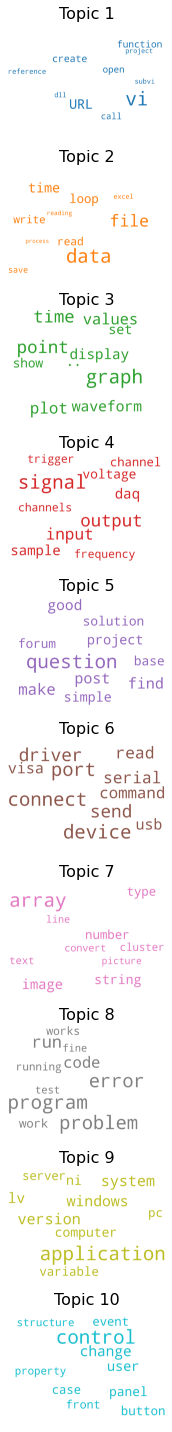

/Users/gurshanrai/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5474 samples in 0.007s...
[t-SNE] Computed neighbors for 5474 samples in 0.297s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5474
[t-SNE] Computed conditional probabilities for sample 2000 / 5474
[t-SNE] Computed conditional probabilities for sample 3000 / 5474
[t-SNE] Computed conditional probabilities for sample 4000 / 5474
[t-SNE] Computed conditional probabilities for sample 5000 / 5474
[t-SNE] Computed conditional probabilities for sample 5474 / 5474
[t-SNE] Mean sigma: 0.025887


/Users/gurshanrai/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.035110
[t-SNE] KL divergence after 1000 iterations: 1.334773


Loading BokehJS ...

show plot


In [57]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamallet.show_topics(formatted=False)

fig, axes = plt.subplots(10, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
print("show word cloud")
plt.show()

# cluster map
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for row_list in ldamallet[corpus]:
  tmp = np.zeros(10)
  for i, w in row_list:
    tmp[i] = w
  topic_weights.append(tmp)

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
print("show plot")
output_file('cluster.html')
show(plot)